# Systemy Multimedialne
System identyfikacji mówcy wykorzystujący konwolucyjne sieci neuronowe

<div>
<img src="assets/SM_schemat_przetwarzania.png" height="600"/>
</div>

### Biblioteki
- `torch`, `torchaudio`, `torchvision` - biblioteki do uczenia maszynowego
- `librosa` - biblioteka do przetwarzania muzyki i dźwięku
- `numpy` - biblioteka do przetwarzania wielowymiarowych macierzy
- `matplotlib` - biblioteka do tworzenia wykresów

In [1]:
import numpy as np

import torch
import torchaudio
import torchaudio.transforms as T
from torch import nn, optim
from torchvision import datasets, models, transforms

import os
import time
import copy
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt

## Przetwarzanie wstępne

In [2]:
import noisereduce as nr


def preprocess_wav(filename):
    waveform, sample_rate = torchaudio.load(filename)

    reduced_noise = nr.reduce_noise(y=waveform, sr=sample_rate, thresh_n_mult_nonstationary=2, stationary=False)

    return reduced_noise, sample_rate

## Ekstrakcja cech - tworzenie spektogramu melowego
Na potrzeby sieci neuronowej, wstępnie przetworzone pliki z mową, zostały przetworzone na spektogramy melowe w rozmiarze 224 x 224 x 3.

Pliki dźwiękowe zostały podzielone na ramki z wykorzystaniem **funkcji okienkującej Hamminga**. Następnie za pomocą transformaty Fouriera, ramki zostały przetworzone na wstępne spektogramy. Przed podaniem ich do sieci, spektogramy zostały zlogratymowane oraz zmapowane do skali melowej.

### Parametry ekstrakcji

In [3]:
DATA_ROOT = './data/data'
TEST_FILE = './data/tests/test_recording.wav'

SAMPLE_RATE = 48000
N_FFT = 2048
FRAME_SIZE = 1024
HOP_SIZE = 215
N_MELS = 224
WINDOW_FN = torch.hamming_window
POWER = 2
PAD_MODE = 'reflect'
NORM = 'slaney'
MEL_SCALE = 'htk'
RESAMPLING_METHOD = 'kaiser_best'

STATIONARY_NR = False
THRESH_N_NR = 2

In [4]:
mel_spectrogram = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    win_length=FRAME_SIZE,
    hop_length=HOP_SIZE,
    n_mels=N_MELS,
    window_fn=WINDOW_FN,
    power=POWER,
    pad_mode=PAD_MODE,
    norm=NORM,
    mel_scale=MEL_SCALE,
)

/Users/limisie/miniconda3/envs/ML/lib/python3.10/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (224) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


In [5]:
def plot_spectrogram(sg, title, ylabel):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title)
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(sg), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_waveform(waveform, sr, title="Waveform"):
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

In [6]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled


def empty_folder(path):
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = librosa.power_to_db(inp).transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

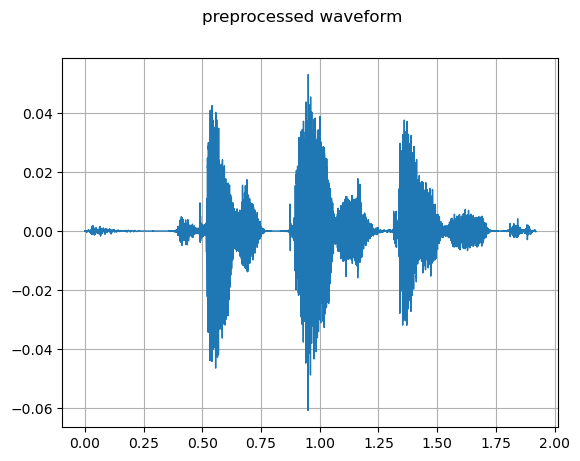

In [7]:
SPEECH_WAVEFORM, SAMPLE_RATE = preprocess_wav(TEST_FILE)
plot_waveform(np.array(SPEECH_WAVEFORM), SAMPLE_RATE, title="preprocessed waveform")
ipd.Audio(SPEECH_WAVEFORM, rate=SAMPLE_RATE)

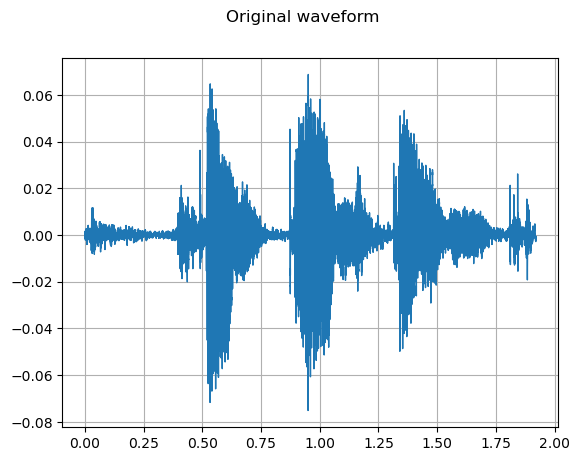

torch.Size([1, 84672])
44100


In [8]:
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(TEST_FILE)
plot_waveform(SPEECH_WAVEFORM.numpy(), SAMPLE_RATE, title="Original waveform")
ipd.Audio(SPEECH_WAVEFORM, rate=SAMPLE_RATE)
print(SPEECH_WAVEFORM.shape)
print(SAMPLE_RATE)

torch.Size([1, 224, 394])


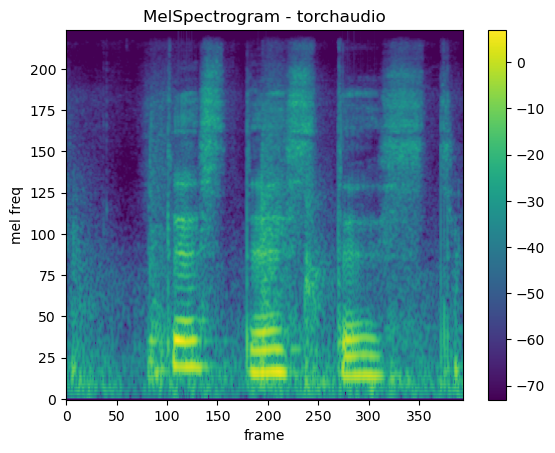

In [9]:
melspec = mel_spectrogram(SPEECH_WAVEFORM)
print(melspec.shape)
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

## Przygotowanie danych

In [10]:
CLASS_NAMES = ['no_speech', 's1_EK', 's2_Konrad', 's3_Kaja', 's4_Radek', 'unknown']
CLASSES = len(CLASS_NAMES)
EPOCHS = 101
BATCH_SIZE = 8
LEARNING_RATE = 1e-7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

img_datasets = {x: datasets.ImageFolder(os.path.join(DATA_ROOT, x), data_transform) for x in
                ['train', 'val', 'test']}

data_loaders = {x: torch.utils.data.DataLoader(img_datasets[x],
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=0)
                for x in ['train', 'val', 'test']}

DATASET_SIZES = {x: len(img_datasets[x]) for x in ['train', 'val', 'test']}

## Przygotowanie sieci konwolucyjnej
### Transfer wiedzy
W systemie skorzystano z metody transferu wiedzy, która polega na użyciu sieci neuronowej wytrenowanej wcześniej w innym, podobnym celu.

Istnieją dwa główne podejścia do transferu wiedzy. Pierwszy polega na zainicjowaniu sieci z wykorzystaniem wstępnie wytrenowanych wag zamiast inicjalizacji losowej i dalszym trenowaniu z wykorzystaniem docelowych danych. Drugie podejście polega na adaptacji wstępnie wyszkolonej sieci jako ekstraktora cech, w którym tylko ostatnia, w pełni połączona warstwa jest losowa inicjowana i trenowana.

W systemie zastosowano drugie podejście i wykorzystano sieć SqueezeNet, wytrenowaną w celu rozpoznawania obiektów za pomocą zbioru danych ImageNet.

In [12]:
from torchvision.models import SqueezeNet1_1_Weights

m_squeezenet = models.squeezenet1_1(weights=SqueezeNet1_1_Weights.DEFAULT)

for param in m_squeezenet.parameters():
    param.requires_grad = False

m_squeezenet.classifier[1] = nn.Conv2d(512, CLASSES, kernel_size=(1, 1), stride=(1, 1))

m_squeezenet = m_squeezenet.to(device)

### Parametry uczenia

In [13]:
model = m_squeezenet
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = None

### Uczenie

In [14]:
def train_model(model, criterion, optimizer, data_loaders, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = {'train': [],
              'val': []}
    accs = {'train': [],
            'val': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / DATASET_SIZES[phase]
            epoch_acc = running_corrects.double() / DATASET_SIZES[phase]

            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc}')

    model.load_state_dict(best_model_wts)
    return model, losses, accs

In [ ]:
model, loss, acc = train_model(model,
                               criterion,
                               optimizer,
                               scheduler,
                               num_epochs=EPOCHS)

torch.save(model, f'../models/m_squeezenet_epochs{EPOCHS}.pt')